In [2]:
import pandas as pd
import numpy as np
import lifelines
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

# 생존 분석 모델 교차 검증 및 C-index 계산 코드 설명

## 1. 코드 목적
- **생존 분석 모델**을 교차 검증(Cross-Validation)을 통해 평가합니다.
- 각 Fold에서 **Concordance Index(C-index)**를 계산하여 모델의 성능을 비교합니다.

---

## 2. 주요 라이브러리
- `numpy` 및 `pandas`: 데이터 처리를 위해 사용.
- `sklearn.model_selection.KFold`: 교차 검증을 위한 데이터 분할.
- `lifelines` 라이브러리:
  - `CoxPHFitter`: Cox Proportional Hazards 모델 학습.
  - `KaplanMeierFitter`: 생존 곡선 모델 (현재 사용하지 않음).
  - `concordance_index`: C-index 계산을 위해 사용.
- `lifelines.datasets.load_rossi`: 예제 데이터셋 로드.

---

## 3. 함수 정의: `cross_validate_survival_models`

### 3.1. 입력 파라미터
- `data`: 분석 데이터셋 (pandas DataFrame).
- `duration_col`: 생존 시간 컬럼명 (ex. `"week"`).
- `event_col`: 이벤트 발생 여부 컬럼명 (1 = 이벤트 발생, 0 = 검열).
- `models`: 생존 분석 모델의 이름과 인스턴스 딕셔너리.
  - 예: `{"Cox Proportional Hazards": CoxPHFitter()}`
- `n_splits`: 교차 검증 Fold 수 (기본값: 5).

### 3.2. 내부 동작
1. `KFold`로 데이터를 `n_splits` 만큼 나눕니다.
2. 각 Fold에서:
   - 학습 데이터(`train_data`)로 모델 학습.
   - 검증 데이터(`test_data`)로 C-index 계산.
3. 모든 Fold에서의 C-index를 리스트에 저장.
4. 각 모델의 평균 C-index를 계산.

### 3.3. 반환값
- `results`: 각 모델의 평균 C-index 딕셔너리.
  - 예: `{"Cox Proportional Hazards": 0.75}`

---

## 4. 데이터 준비
- **데이터셋**: `lifelines.datasets.load_rossi`를 사용.
  - `week`: 생존 시간.
  - `arrest`: 이벤트 발생 여부 (1 = 이벤트 발생, 0 = 검열).

---

## 5. 사용된 생존 모델
- **Cox Proportional Hazards 모델**:
  - `lifelines.CoxPHFitter`를 사용하여 학습.

---

## 6. 코드 실행 결과
- 각 모델의 평균 C-index를 출력.

### 출력 예시
```plaintext
Cross-Validation Results (C-index):
Cox Proportional Hazards: 0.7634


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.datasets import load_rossi

# 생존 모델 교차 검증 함수 정의
def cross_validate_survival_models(data, duration_col, event_col, models, n_splits=2):
    """
    생존 분석 모델을 교차 검증하여 C-index를 계산하는 함수.

    Parameters:
    - data: pd.DataFrame, 분석 데이터셋
    - duration_col: str, 생존 시간 컬럼명
    - event_col: str, 이벤트 발생 여부 컬럼명 (1 = 이벤트 발생, 0 = 검열)
    - models: dict, 생존 분석 모델의 이름과 인스턴스 딕셔너리
    - n_splits: int, 교차 검증 Fold 수

    Returns:
    - results: dict, 각 모델의 평균 C-index
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {model_name: [] for model_name in models.keys()}

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        for model_name, model in models.items():
            # 모델 학습
            if hasattr(model, "fit"):
                model.fit(train_data, duration_col=duration_col, event_col=event_col)
            else:
                raise ValueError(f"Model {model_name} does not have a fit method.")

            # 예측 및 C-index 계산
            if hasattr(model, "predict_partial_hazard"):
                predictions = model.predict_partial_hazard(test_data)
            else:
                raise ValueError(f"Model {model_name} does not support predict_partial_hazard.")

            c_index = concordance_index(
                test_data[duration_col],
                -predictions,  # 낮은 값이 높은 위험으로 간주되므로 부호 반전
                test_data[event_col]
            )
            results[model_name].append(c_index)

    # 각 모델의 평균 C-index 계산
    avg_results = {model_name: np.mean(scores) for model_name, scores in results.items()}
    return avg_results

# 데이터 로드
# 데이터 로드시, duration_col, event_indicator 그리고 그 이외의 독립변수들을 모두 포함한 데이터로 로드
data = pd.read_csv('C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv')
data = data[['sex','tx_1','tx_2','tx_3','tx_4','tx_5','seer_TF','event_inc','stime']]



# 사용할 생존 분석 모델 정의
models = {
    "Cox Proportional Hazards": CoxPHFitter(),
    # 다른 모델도 추가 가능 (예: Accelerated Failure Time 모델 등)
}


# 교차 검증 수행
results = cross_validate_survival_models(
    data=data,
    duration_col="stime",
    event_col="event_inc",
    models=models,
    n_splits=5
)

# 결과 출력
print("Cross-Validation Results (C-index):")
for model_name, c_index in results.items():
    print(f"{model_name}: {c_index:.4f}")


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import WeibullAFTFitter, LogNormalAFTFitter
from lifelines import CoxPHFitter
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.preprocessing import StandardScaler

# 생존 모델 교차 검증 함수 정의
def cross_validate_survival_models(data, duration_col, event_col, models, frailty_col=None, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {model_name: [] for model_name in models.keys()}

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        for model_name, model in models.items():
            # Frailty 모델의 경우 cluster_col 추가
            if model_name == "Frailty Model" and frailty_col:
                model.fit(train_data, duration_col=duration_col, event_col=event_col, cluster_col=frailty_col)
            else:
                model.fit(train_data, duration_col=duration_col, event_col=event_col)

            # 모델별 예측 메서드 선택
            if isinstance(model, CoxPHFitter):  # Cox 모델
                predictions = model.predict_partial_hazard(test_data)
            elif isinstance(model, (WeibullAFTFitter, LogNormalAFTFitter)):  # AFT 모델
                predictions = model.predict_median(test_data)  # 중앙 생존 시간 예측
            else:  # sksurv 모델
                predictions = model.predict(test_data.drop(columns=[duration_col, event_col]))

            # C-index 계산
            c_index = concordance_index(
                test_data[duration_col], -predictions, test_data[event_col]
            )
            results[model_name].append(c_index)

    avg_results = {model_name: np.mean(scores) for model_name, scores in results.items()}
    return avg_results

# 데이터 로드 및 확인
data = pd.read_csv('C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv')
duration_col = "stime"      # 생존 시간
event_col = "event_inc"     # 이벤트 발생 여부
frailty_col = "gu_encoded"          # 프레일티 항으로 사용할 컬럼
data = data[['sex', 'tx_1', 'tx_2', 'tx_3', 'tx_4', 'tx_5', 'seer_TF','gu_encoded','stime','event_inc']]
# stime 값이 0 이하인 경우 0.01로 수정
data['stime'] = data['stime'].apply(lambda x: 0.01 if x <= 0 else x)

# 독립변수 스케일링 (CoxnetSurvivalAnalysis를 위한 전처리)
#scaler = StandardScaler()
#X = data[['sex', 'tx_1', 'tx_2', 'tx_3', 'tx_4', 'tx_5', 'seer_TF','gu_encoded']]
#X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#data = pd.concat([data[[duration_col, event_col, frailty_col]], X_scaled], axis=1)

# 사용할 생존 분석 모델 정의
models = {
    "Cox Proportional Hazards": CoxPHFitter(),
#     "Weibull AFT Model": WeibullAFTFitter(),
#     "Log-Normal AFT Model": LogNormalAFTFitter(),
    "Frailty Model": CoxPHFitter(),  # 프레일티 모델은 gu 컬럼으로 클러스터 지정
    "Cox PH (Ridge)": CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.0),
    "Cox PH (Lasso)": CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)
}

# 교차 검증 수행
results = cross_validate_survival_models(
    data=data,
    duration_col=duration_col,
    event_col=event_col,
    models=models,
    frailty_col=frailty_col,
    n_splits=5
)

# 결과 출력
print("Cross-Validation Results (C-index):")
for model_name, c_index in results.items():
    print(f"{model_name}: {c_index:.4f}")


TypeError: fit() got an unexpected keyword argument 'duration_col'

In [25]:
# stime 컬럼의 고유값 중 0 이하인 값 확인
unique_stime = data['stime'].unique()

for value in unique_stime:
    if value <= 0:
        print(f"0 이하 값 발견: {value}")

0 이하 값 발견: 0


# 생존 분석을 위한 변수 처리 및 분석 방법

## 1. 성별 변수(Standard Scaling 필요성)
- **성별 변수**: 1=여자, 2=남자  
  성별 변수는 **범주형 변수**로서, 숫자 값 자체에는 의미가 없기 때문에 **Standard Scaling**을 할 필요가 없습니다.
- **대안 방법**:
  - 숫자 값으로 그대로 사용하지 않고 **더미 변수화(One-Hot Encoding)** 하는 것이 적절합니다.
    ```python
    data = pd.get_dummies(data, columns=["sex"], drop_first=True)
    ```
    - `drop_first=True`를 설정하면 첫 번째 범주(여자)를 기준으로 더미 변수를 생성합니다.  
    - 결과적으로 남자(2)에 대해 `sex_2`라는 이진 변수(0, 1)가 생성됩니다.
  - **더미 변수를 사용하지 않고 그대로 입력**: Cox 모델과 같은 선형 모델에서는 그대로 입력해도 크게 문제되지 않지만 해석상 주의해야 합니다.

---

## 2. 치료 변수(tx_1, tx_2, tx_3, tx_4, tx_5) 분석 방법
- 치료 변수들은 **더미 변수화된 상태**로 보입니다.  
  예를 들어 `tx_1=1, tx_2=0, ...`인 경우는 수술만 수행한 경우를 의미합니다. 

### **분석 방법**
1. **모델 입력**:
   - 각 치료 변수(`tx_1, tx_2, ...`)를 **독립 변수**로 그대로 모델에 입력합니다.
   - `Cox 모델`의 경우 각 치료가 생존 시간에 미치는 **위험비(Hazard Ratio)**를 계산할 수 있습니다.

2. **수준별 비교**:
   - 치료가 하나만 적용된 경우(예: `tx_1=1, tx_2=tx_3=tx_4=tx_5=0`)를 기준군으로 설정하고,
   - 다른 치료 또는 복합 치료를 수행한 그룹과 비교합니다.
   - **생존 곡선**을 비교하고, 특정 치료가 생존 시간에 미치는 영향을 시각화할 수 있습니다.
     ```python
     from lifelines import KaplanMeierFitter
     import matplotlib.pyplot as plt

     kmf = KaplanMeierFitter()

     # 수술만 받은 그룹
     group1 = data[(data['tx_1'] == 1) & (data['tx_2'] == 0) & (data['tx_3'] == 0) & (data['tx_4'] == 0) & (data['tx_5'] == 0)]
     # 화학요법만 받은 그룹
     group2 = data[(data['tx_2'] == 1) & (data['tx_1'] == 0)]

     # 생존 곡선 비교
     kmf.fit(group1['stime'], event_observed=group1['event_inc'], label='Surgery Only')
     kmf.plot()
     kmf.fit(group2['stime'], event_observed=group2['event_inc'], label='Chemotherapy Only')
     kmf.plot()
     plt.title("Survival Curves by Treatment Type")
     plt.show()
     ```

3. **치료 변수의 상호작용**:
   - 여러 치료가 동시에 수행된 경우를 고려하여 **상호작용 효과**를 분석할 수 있습니다.
   - 예를 들어 `tx_1 * tx_2`와 같은 항을 추가해 모델에 입력합니다.

4. **변수 선택**:
   - Lasso 정규화를 사용해 중요도가 높은 치료 변수를 선택할 수 있습니다.

---

## 3. 전이 여부 변수(seer_TF) 분석 방법
- `seer_TF`: 1=전이O, 0=전이X  
  **전이 여부**는 이진 변수이며 생존 시간에 중요한 영향을 미칠 수 있는 **주요 예측 변수**입니다.

### **분석 방법**
1. **Cox 모델에서 사용**:
   - 전이 여부를 **독립 변수**로 모델에 포함합니다.
   - **Hazard Ratio**를 통해 전이 여부가 생존 시간에 미치는 위험도를 평가할 수 있습니다.
     ```python
     cph = CoxPHFitter()
     cph.fit(data, duration_col="stime", event_col="event_inc")
     cph.print_summary()  # seer_TF의 Hazard Ratio 확인
     ```

2. **Kaplan-Meier 생존 곡선 비교**:
   - 전이 여부에 따라 생존 곡선을 비교합니다.
     ```python
     kmf = KaplanMeierFitter()

     # 전이O 그룹
     group1 = data[data['seer_TF'] == 1]
     kmf.fit(group1['stime'], event_observed=group1['event_inc'], label='Metastasis (Yes)')
     kmf.plot()

     # 전이X 그룹
     group2 = data[data['seer_TF'] == 0]
     kmf.fit(group2['stime'], event_observed=group2['event_inc'], label='Metastasis (No)')
     kmf.plot()

     plt.title("Survival Curves by Metastasis Status")
     plt.show()
     ```

3. **전이 여부와 다른 변수의 상호작용 분석**:
   - 전이가 되었는지 여부와 치료 방법(`tx_1 ~ tx_5`) 사이의 상호작용을 추가해 모델에 포함합니다.
   - 예: `seer_TF * tx_1` 항목을 추가.

---

## **요약**
1. **성별**: 더미 변수화(One-Hot Encoding) 적용.
2. **치료 변수**:
   - 개별 변수로 사용해 생존 시간에 미치는 영향 평가.
   - 생존 곡선을 통해 치료별 비교.
   - 상호작용 효과 분석 가능.
3. **전이 여부(seer_TF)**:
   - 생존 곡선으로 그룹 비교.
   - Cox 모델에서 주요 예측 변수로 사용.
   - 다른 변수와의 상호작용 항 추가 분석.


In [7]:
## standard scaler 적용시의 값 확인해보기
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = data[['sex', 'tx_1', 'tx_2', 'tx_3', 'tx_4', 'tx_5', 'seer_TF']]
# X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# X_scaled

,sex,tx_1,tx_2,tx_3,tx_4,tx_5,seer_TF
0,1.210842,0.518645,1.298485,-0.293047,-0.114147,-0.019564,0.786903
1,1.210842,0.518645,1.298485,-0.293047,-0.114147,-0.019564,-1.270805
2,-0.825871,0.518645,1.298485,-0.293047,-0.114147,-0.019564,-1.270805
3,-0.825871,0.518645,1.298485,-0.293047,-0.114147,-0.019564,0.786903
4,1.210842,0.518645,-0.770129,-0.293047,-0.114147,-0.019564,-1.270805
...,...,...,...,...,...,...,...
33971,-0.825871,0.518645,-0.770129,-0.293047,-0.114147,-0.019564,0.786903
33972,-0.825871,0.518645,-0.770129,-0.293047,-0.114147,-0.019564,0.786903
33973,-0.825871,0.518645,-0.770129,-0.293047,-0.114147,-0.019564,-1.270805
33974,-0.825871,0.518645,1.298485,-0.293047,-0.114147,-0.019564,0.786903


In [9]:
### '구' 로 클러스터를 나누었을때, 각각의 클러스터에 속한 값들의 갯수 확인
# data = pd.read_csv('C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv')
# data['gu'].value_counts()

gu
해운대구    3705
부산진구    3690
사하구     3209
남구      3147
북구      2654
연제구     2554
동래구     2458
금정구     2420
사상구     2033
수영구     1831
영도구     1455
서구      1342
동구      1244
기장군     1046
강서구      655
중구       533
Name: count, dtype: int64

# 클래스화

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter, WeibullAFTFitter, LogNormalAFTFitter
from lifelines.utils import concordance_index
from sksurv.linear_model import CoxnetSurvivalAnalysis
import matplotlib.pyplot as plt

class SurvivalAnalysis:
    def __init__(self, data, duration_col, event_col, frailty_col=None):
        """
        Initialize the SurvivalAnalysis class.

        Parameters:
        - data: DataFrame containing the dataset.
        - duration_col: Name of the column with survival times.
        - event_col: Name of the column with event occurrence.
        - frailty_col: Name of the column for clustering (optional).
        """
        self.data = data
        self.duration_col = duration_col
        self.event_col = event_col
        self.frailty_col = frailty_col
        self.models = {}

    def add_cox_model(self, name="Cox Proportional Hazards"):
        """Add a Cox Proportional Hazards model."""
        def model_func(train_data):
            model = CoxPHFitter()
            model.fit(train_data, duration_col=self.duration_col, event_col=self.event_col)
            return model
        self.models[name] = model_func

    def add_frailty_model(self, name="Frailty Model"):
        """Add a Frailty model."""
        if not self.frailty_col:
            raise ValueError("Frailty column must be specified for Frailty Model.")
        def model_func(train_data):
            model = CoxPHFitter()
            model.fit(train_data, duration_col=self.duration_col, event_col=self.event_col, cluster_col=self.frailty_col)
            return model
        self.models[name] = model_func

    def add_weibull_aft_model(self, name="Weibull AFT Model"):
        """Add a Weibull Accelerated Failure Time model."""
        def model_func(train_data):
            model = WeibullAFTFitter()
            model.fit(train_data, duration_col=self.duration_col, event_col=self.event_col)
            return model
        self.models[name] = model_func

    def add_lognormal_aft_model(self, name="Log-Normal AFT Model"):
        """Add a Log-Normal Accelerated Failure Time model."""
        def model_func(train_data):
            model = LogNormalAFTFitter()
            model.fit(train_data, duration_col=self.duration_col, event_col=self.event_col)
            return model
        self.models[name] = model_func

    def add_coxnet_model(self, name="Cox PH (Ridge)", alpha_min_ratio=0.01, l1_ratio=0.0):
        """Add a CoxNet model (Ridge or Lasso regularization)."""
        def model_func(train_data):
            X = train_data.drop(columns=[self.duration_col, self.event_col])
            y = train_data[[self.duration_col, self.event_col]].to_numpy()
            model = CoxnetSurvivalAnalysis(alpha_min_ratio=alpha_min_ratio, l1_ratio=l1_ratio)
            model.fit(X, y)
            return model
        self.models[name] = model_func

    def cross_validate(self, n_splits=5):
        """
        Perform cross-validation on all added models.

        Parameters:
        - n_splits: Number of folds for cross-validation.

        Returns:
        - A dictionary with average C-index for each model.
        - A dictionary with all fold-wise C-index scores for each model.
        """
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        results = {model_name: [] for model_name in self.models.keys()}

        for train_index, test_index in kf.split(self.data):
            train_data = self.data.iloc[train_index]
            test_data = self.data.iloc[test_index]

            for model_name, model_func in self.models.items():
                model = model_func(train_data)

                if isinstance(model, CoxPHFitter):
                    predictions = model.predict_partial_hazard(test_data)
                elif isinstance(model, (WeibullAFTFitter, LogNormalAFTFitter)):
                    predictions = model.predict_median(test_data)
                else:
                    predictions = model.predict(test_data.drop(columns=[self.duration_col, self.event_col]))

                c_index = concordance_index(
                    test_data[self.duration_col], -predictions, test_data[self.event_col]
                )
                results[model_name].append(c_index)

        avg_results = {model_name: np.mean(scores) for model_name, scores in results.items()}
        return avg_results, results

    def plot_results(self, results):
        """
        Plot a boxplot of the C-index scores for all models.

        Parameters:
        - results: A dictionary with fold-wise C-index scores for each model.
        """
        plt.figure(figsize=(10, 6))
        data = [scores for scores in results.values()]
        labels = list(results.keys())

        plt.boxplot(data, labels=labels, vert=True, patch_artist=True)
        plt.ylabel("C-index")
        plt.title("Cross-Validation C-index Scores by Model")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv')
    duration_col = "stime"
    event_col = "event_inc"
    frailty_col = "gu_encoded"

    # Preprocess data
    data = data[['sex', 'tx_1', 'tx_2', 'tx_3', 'tx_4', 'tx_5', 'seer_TF', 'gu_encoded', 'stime', 'event_inc']]
    data['stime'] = data['stime'].apply(lambda x: 0.01 if x <= 0 else x)

    # Initialize SurvivalAnalysis class
    sa = SurvivalAnalysis(data, duration_col, event_col, frailty_col)

    # Add models
    sa.add_cox_model()
    sa.add_frailty_model()
    sa.add_weibull_aft_model()
    sa.add_lognormal_aft_model()
    sa.add_coxnet_model(name="Cox PH (Ridge)", l1_ratio=0.0)
    sa.add_coxnet_model(name="Cox PH (Lasso)", l1_ratio=1.0)

    # Perform cross-validation
    avg_results, all_results = sa.cross_validate()

    # Print results
    print("Cross-Validation Results (C-index):")
    for model_name, c_index in avg_results.items():
        print(f"{model_name}: {c_index:.4f}")

    # Plot results
    sa.plot_results(all_results)


Cross-Validation C-index Scores: [0.7089555196631866, 0.6986870244498198, 0.709480806918522, 0.7036798350616027, 0.6964293046828218]
Average C-index: 0.7034464981551906


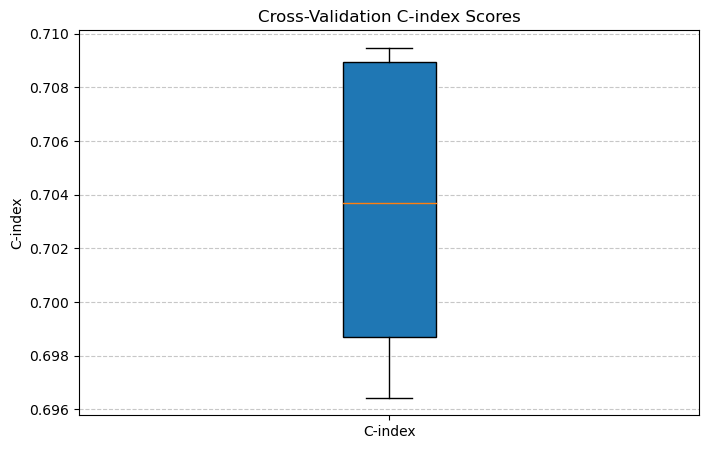

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter, WeibullAFTFitter, LogNormalAFTFitter
from lifelines.utils import concordance_index
from sksurv.linear_model import CoxnetSurvivalAnalysis
import matplotlib.pyplot as plt

class SurvivalAnalysis:
    def __init__(self, data, duration_col, event_col, frailty_col=None):
        """
        Initialize the SurvivalAnalysis class.

        Parameters:
        - data: DataFrame containing the dataset.
        - duration_col: Name of the column with survival times.
        - event_col: Name of the column with event occurrence.
        - frailty_col: Name of the column for clustering (optional).
        """
        self.data = data
        self.duration_col = duration_col
        self.event_col = event_col
        self.frailty_col = frailty_col
        self.selected_model = None

    def select_model(self, model_name, **kwargs):
        """Select a specific survival model to use for analysis."""
        if model_name == "Cox Proportional Hazards":
            self.selected_model = lambda train_data: self._fit_cox(train_data)
        elif model_name == "Frailty Model":
            if not self.frailty_col:
                raise ValueError("Frailty column must be specified for Frailty Model.")
            self.selected_model = lambda train_data: self._fit_frailty(train_data)
        elif model_name == "Weibull AFT Model":
            self.selected_model = lambda train_data: self._fit_weibull_aft(train_data)
        elif model_name == "Log-Normal AFT Model":
            self.selected_model = lambda train_data: self._fit_lognormal_aft(train_data)
        elif model_name == "Cox PH (Ridge)":
            self.selected_model = lambda train_data: self._fit_coxnet(train_data, l1_ratio=kwargs.get("l1_ratio", 0.0))
        elif model_name == "Cox PH (Lasso)":
            self.selected_model = lambda train_data: self._fit_coxnet(train_data, l1_ratio=kwargs.get("l1_ratio", 1.0))
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def _fit_cox(self, train_data):
        model = CoxPHFitter()
        model.fit(train_data, duration_col=self.duration_col, event_col=self.event_col)
        return model

    def _fit_frailty(self, train_data):
        model = CoxPHFitter()
        model.fit(train_data, duration_col=self.duration_col, event_col=self.event_col, cluster_col=self.frailty_col)
        return model

    def _fit_weibull_aft(self, train_data):
        model = WeibullAFTFitter()
        model.fit(train_data, duration_col=self.duration_col, event_col=self.event_col)
        return model

    def _fit_lognormal_aft(self, train_data):
        model = LogNormalAFTFitter()
        model.fit(train_data, duration_col=self.duration_col, event_col=self.event_col)
        return model

    def _fit_coxnet(self, train_data, l1_ratio):
        X = train_data.drop(columns=[self.duration_col, self.event_col])
        y = train_data[[self.duration_col, self.event_col]].to_numpy()
        model = CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=l1_ratio)
        model.fit(X, y)
        return model

    def cross_validate(self, n_splits=5):
        """
        Perform cross-validation with the selected model.

        Parameters:
        - n_splits: Number of folds for cross-validation.

        Returns:
        - A list with fold-wise C-index scores.
        """
        if not self.selected_model:
            raise ValueError("No model has been selected. Use `select_model` to choose a model.")

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        c_indices = []

        for train_index, test_index in kf.split(self.data):
            train_data = self.data.iloc[train_index]
            test_data = self.data.iloc[test_index]

            model = self.selected_model(train_data)

            if isinstance(model, CoxPHFitter):
                predictions = model.predict_partial_hazard(test_data)
            elif isinstance(model, (WeibullAFTFitter, LogNormalAFTFitter)):
                predictions = model.predict_median(test_data)
            else:
                predictions = model.predict(test_data.drop(columns=[self.duration_col, self.event_col]))

            c_index = concordance_index(
                test_data[self.duration_col], -predictions, test_data[self.event_col]
            )
            c_indices.append(c_index)

        return c_indices

    def plot_results(self, c_indices):
        """
        Plot a boxplot of the C-index scores for the selected model.

        Parameters:
        - c_indices: A list with fold-wise C-index scores.
        """
        plt.figure(figsize=(8, 5))
        plt.boxplot(c_indices, vert=True, patch_artist=True, labels=["C-index"])
        plt.ylabel("C-index")
        plt.title("Cross-Validation C-index Scores")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv')
    duration_col = "stime"
    event_col = "event_inc"
    frailty_col = "gu_encoded"

    # Preprocess data
    data = data[['sex', 'tx_1', 'tx_2', 'tx_3', 'tx_4', 'tx_5', 'seer_TF', 'gu_encoded', 'stime', 'event_inc']]
    data['stime'] = data['stime'].apply(lambda x: 0.01 if x <= 0 else x)

    # Initialize SurvivalAnalysis class
    sa = SurvivalAnalysis(data, duration_col, event_col, frailty_col)

    # Select and evaluate a model
    sa.select_model("Cox Proportional Hazards")
    c_indices = sa.cross_validate()

    # Print results
    print("Cross-Validation C-index Scores:", c_indices)
    print("Average C-index:", np.mean(c_indices))

    # Plot results
    sa.plot_results(c_indices)


Cross-Validation C-index Scores: [np.float64(0.7089176376016699), np.float64(0.6989407545013664), np.float64(0.7095935724767961), np.float64(0.7038908318756413), np.float64(0.6967485889752679)]
Average C-index: 0.7036182770861483


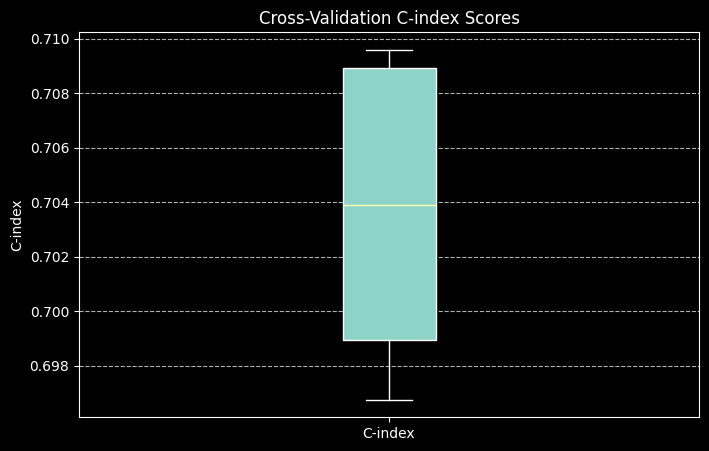

In [6]:
from survival_analysis import SurvivalAnalysis
import pandas as pd
import numpy as np

# load_data
data = pd.read_csv("C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv")
duration_col = "stime"
event_col = "event_inc"
frailty_col = "gu_encoded"

# Preprocess data
data = data[['sex','tx_1','tx_2','tx_3','seer_TF','gu_encoded','stime','event_inc']]
data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

# Initialize SurvivalAnalysis class
sa = SurvivalAnalysis(data, duration_col, event_col, frailty_col)

# Select and evaluate a model
sa.select_model("Cox Proportional Hazards")
c_indices = sa.cross_validate()

# Print results
print("Cross-Validation C-index Scores:", c_indices)
print("Average C-index:", np.mean(c_indices))

# Plot results
sa.plot_results(c_indices)


Cross-Validation C-index Scores: [np.float64(0.7089176376016699), np.float64(0.6989407545013664), np.float64(0.7095935724767961), np.float64(0.7038908318756413), np.float64(0.6967485889752679)]
Average C-index: 0.7036182770861483


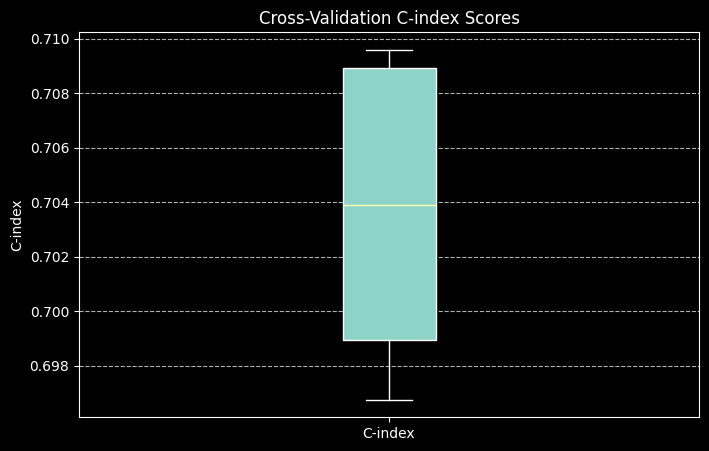

In [ ]:
from survival_analysis import SurvivalAnalysis
import pandas as pd
import numpy as np

# load_data
data = pd.read_csv("C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv")
duration_col = "stime"
event_col = "event_inc"
frailty_col = "gu_encoded"

# Preprocess data
data = data[['sex','tx_1','tx_2','tx_3','seer_TF','gu_encoded','stime','event_inc']]
data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

# Initialize SurvivalAnalysis class
sa = SurvivalAnalysis(data, duration_col, event_col, frailty_col)

# Select and evaluate a model
sa.select_model("Cox Proportional Hazards")
c_indices = sa.cross_validate()

# Print results
print("Cross-Validation C-index Scores:", c_indices)
print("Average C-index:", np.mean(c_indices))

# Plot results
sa.plot_results(c_indices)
